In [1]:
import unittest
import matplotlib
from neuronunit.allenapi.allen_data_driven import opt_setup, opt_setup_two, opt_exec
from neuronunit.allenapi.allen_data_driven import opt_to_model,wrap_setups
from neuronunit.allenapi.utils import dask_map_function

/home/user/anaconda3/lib/python3.7/site-packages/cerberus/validator.py:1609: UserWarning: No validation schema is defined for the arguments of rule 'not_zero_obs_zscore'
  "'%s'" % method_name.split('_', 2)[-1]
/home/user/anaconda3/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)
test


In [2]:
from neuronunit.optimization.optimization_management import check_bin_vm_soma
from neuronunit.optimization.model_parameters import MODEL_PARAMS, BPO_PARAMS, to_bpo_param
from neuronunit.optimization.optimization_management import dtc_to_rheo,inject_and_plot_model
import numpy as np
from neuronunit.optimization.data_transport_container import DataTC
import efel
from jithub.models import model_classes
import matplotlib.pyplot as plt
import quantities as qt
import os
from sciunit.scores import RelativeDifferenceScore,ZScore

In [3]:


class testOptimization(unittest.TestCase):
    def setUp(self):
        self = self
        self.ids = [ 324257146,
                325479788,
                476053392,
                623893177,
                623960880,
                482493761,
                471819401
               ]
        self.specimen_id = self.ids[1]
    def reuse(self,model_type,score_type=ZScore):

        target_num_spikes = 8
        dtc = DataTC()
        dtc.backend = model_type
        dtc.attrs = {k:np.mean(v) for k,v in MODEL_PARAMS[model_type].items()}
        model = dtc.dtc_to_model()
        model.params = BPO_PARAMS[model_type]
        fixed_current = 122 *qt.pA
        NGEN = 45
        MU = 15
        mapping_funct = dask_map_function
        cell_evaluator,simple_cell,suite,target_current,spk_count = wrap_setups(
                  self.specimen_id,
                  model_type,
                  target_num_spikes,
                  template_model=model,
                  fixed_current=False,
                  cached=True,
                  score_type=score_type
        )
        #cell_evaluator.
        final_pop, hall_of_fame, logs, hist = opt_exec(MU,NGEN,mapping_funct,cell_evaluator)
        opt,target = opt_to_model(hall_of_fame,cell_evaluator,suite, target_current, spk_count)
        best_ind = hall_of_fame[0]
        fitnesses = cell_evaluator.evaluate_with_lists(best_ind)
        target.vm_soma = suite.traces['vm15']
        check_bin_vm_soma(target,opt)
        print('met fitness goals')
        print(0.7>np.sum(fitnesses))
    def test_opt_relative_diff(self):
        model_type = "ADEXP"
        self.reuse(model_type,score_type=RelativeDifferenceScore)

    def test_opt_ZScore(self):
        model_type = "ADEXP"
        self.reuse(model_type,score_type=ZScore)
    def test_opt_relative_diff_izhi(self):
        model_type = "IZHI"
        self.reuse(model_type,score_type=RelativeDifferenceScore)

    def test_opt_ZScore_izhi(self):
        model_type = "IZHI"
        self.reuse(model_type,score_type=ZScore)


In [4]:
tt = testOptimization()
tt.setUp()

# Z score works

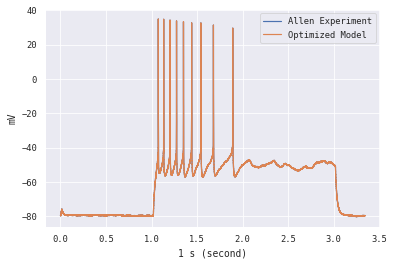

ADEXPModel <jithub.models.backends.adexp.JIT_ADEXPBackend object at 0x7fb7906d9490>
ADEXPModel <jithub.models.backends.adexp.JIT_ADEXPBackend object at 0x7fb7906d9490>


gen	nevals	avg    	std    	min    	max    
1  	15    	2044.48	5303.82	4.84959	17010.8


2  	9     	5082.57	8419.02	4.84959	22000  
3  	13    	15.5641	6.72433	4.26997	28.7877
4  	11    	468.567	1598.19	3.31105	6004.85
5  	10    	2175.7 	3074.36	3.31105	7004.18
6  	6     	5605.02	2797.48	3.31105	7004.64
7  	10    	5604.69	2797.46	3.31105	7003.42
8  	12    	1175.47	2606.35	3.31105	7003.42
9  	10    	1005.66	2448.64	2.87303	7003.71
10 	9     	11.5117	2.03616	2.87303	11.9916
11 	10    	11.485 	2.08872	2.87303	11.9916
12 	12    	11.5117	2.03616	2.87303	11.9916
13 	12    	7.59655	4.04879	1.79909	11.9916
14 	9     	504.901	1500.87	1.79909	6005.93
15 	10    	580.009	1594.72	1.79909	6011.02
16 	10    	147.574	516.195	1.79909	2008.72
17 	10    	406.736	803.655	1.69385	2019.35
18 	9     	293.219	708.264	1.65787	2034.67
19 	10    	312.466	725.742	0.896394	2021.5 
20 	11    	1342.97	2213.24	0.896394	6018.09
21 	5     	621.179	1648.87	0.896394	6024.15
22 	11    	1076.77	2053.27	0.896394	6024.15
23 	10    	2462.35	2935   	0.896394	7002.7 
24 	10    	875.372	2218.82	0.896394	7018.49
25 	7

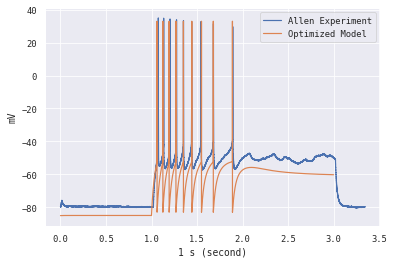

met fitness goals
True


In [5]:

tt.test_opt_ZScore()


# Relative DIfference Does not work

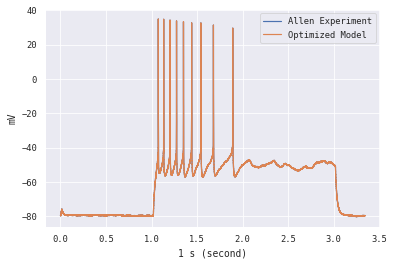

ADEXPModel <jithub.models.backends.adexp.JIT_ADEXPBackend object at 0x7fb788b08090>
ADEXPModel <jithub.models.backends.adexp.JIT_ADEXPBackend object at 0x7fb788b08090>


gen	nevals	avg    	std   	min    	max    
1  	15    	1936.37	5333.2	26.9873	17020.7


2  	9     	5038.32	8444.39	26.9873	22000  
3  	13    	31.5086	5.11603	18.4198	34.5861
4  	10    	28.5632	2.88033	18.4198	30.8382
5  	10    	1627.74	2761.48	18.4198	7023.38
6  	11    	1572.37	2460.68	18.4198	7021.6 
7  	10    	138.957	472.114	18.4198	2027.34
8  	9     	17.913 	2.15027	8.79015	18.4198
9  	10    	18.6058	3.73722	8.79015	31.584 
10 	10    	17.4474	4.82235	8.11526	26.5852
11 	10    	15.5305	6.3327 	8.11526	26.5563
12 	14    	12.0075	3.02631	6.16188	15.9742
13 	10    	10.3423	3.41816	6.16188	15.6865
14 	11    	13.1575	4.58409	6.16188	24.1348
15 	11    	12.6275	3.9808 	6.16188	16.8987
16 	13    	14.2723	2.29551	6.16188	15.902 
17 	11    	12.4392	4.2143 	6.16188	15.7304
18 	10    	15.3087	4.5374 	6.16188	32.2716
19 	10    	11.7491	3.54636	5.62094	15.8822
20 	8     	12.2839	4.51275	5.62094	23.2457
21 	9     	11.1443	4.79152	5.62094	20.7183
22 	11    	5.62094	0      	5.62094	5.62094
23 	13    	6.15292	2.25702	5.62094	15.7286
24 	10    	7.49782	5.67989	5.62094	28.1442
25 	12    	

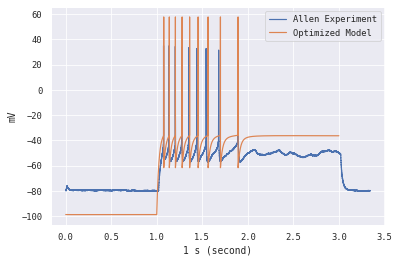

met fitness goals
False


In [6]:

tt.test_opt_relative_diff()

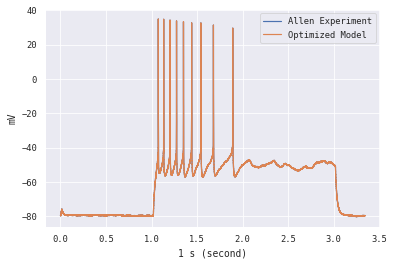

IzhiModel <jithub.models.backends.izhikevich.JIT_IZHIBackend object at 0x7fb78b47abd0>
IzhiModel <jithub.models.backends.izhikevich.JIT_IZHIBackend object at 0x7fb78b47abd0>


gen	nevals	avg    	std   	min    	max  
1  	15    	2036.87	6312.9	33.9199	22000


2  	12    	3033.86	7536.38	33.9199	22000
3  	10    	34.5971	1.84846	32.5678	38.8448
4  	7     	35.7017	1.27945	31.8611	37.4264
5  	9     	34.7173	1.75532	31.8611	37.4215
6  	11    	35.9263	5.12849	31.8611	49.0724
7  	11    	37.7537	5.73399	31.8611	46.2531
8  	11    	42.5871	5.21683	31.8611	47.9995
9  	10    	45.3488	3.21138	31.8611	46.4338
10 	9     	45.4353	3.22158	31.8611	46.7383
11 	6     	45.4046	3.20733	31.8611	46.4338
12 	8     	45.3053	3.19107	31.8611	46.4995
13 	12    	45.0354	3.13237	31.8611	46.7167
14 	10    	44.1891	3.53652	31.8611	46.137 
15 	9     	41.9869	4.70955	31.8611	47.7056
16 	9     	42.1846	4.10008	31.8611	46.154 
17 	10    	43.9136	3.23956	31.8611	45.9592
18 	9     	44.2439	3.01917	31.8611	46.1109
19 	11    	40.1021	6.13341	31.8611	47.083 
20 	11    	33.0788	0.615611	31.8611	34.1856
21 	7     	33.0516	0.95546 	31.7491	34.1856
22 	12    	34.2382	3.5799  	31.7491	49.0227
23 	9     	37.7396	6.27006 	31.7491	49.05  
24 	8     	40.5561	7.50917 	31.7491	49.0227
25 	9   

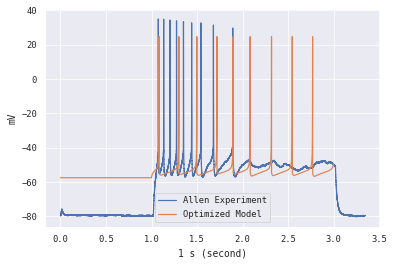

met fitness goals
False


In [7]:
tt.test_opt_relative_diff_izhi()



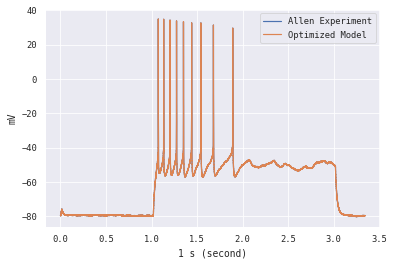

IzhiModel <jithub.models.backends.izhikevich.JIT_IZHIBackend object at 0x7fb788b17910>
IzhiModel <jithub.models.backends.izhikevich.JIT_IZHIBackend object at 0x7fb788b17910>


AttributeError: 'float' object has no attribute 'lower_bound'

In [9]:
tt.test_opt_ZScore_izhi()